# Recommender System

[Yahoo! Music User Ratings of Musical Artists, version 1.0 (423 MB)](http://webscope.sandbox.yahoo.com/catalog.php?datatype=r&did=1)
    This dataset represents a snapshot of the Yahoo! Music community's preferences for various musical artists. The dataset contains over ten million ratings of musical artists given by Yahoo! Music users over the course of a one month period sometime prior to March 2004. Users are represented as meaningless anonymous numbers so that no identifying information is revealed. The dataset may be used by researchers to validate recommender systems or collaborative filtering algorithms. The dataset may serve as a testbed for matrix and graph algorithms including PCA and clustering algorithms. The size of this dataset is 423 MB.

From the readme.txt:
```
This dataset consists of two files:
1. ydata-ymusic-user-artist-ratings-v1_0.txt
2. ydata-ymusic-artist-names-v1_0.txt

The content of the two files are as follows:

=====================================================================

(1) "ydata-ymusic-user-artist-ratings-v1_0.txt" contains user ratings
    of music artists. It contains 11,557,943 ratings of 98,211 artists
    by 1,948,882 anonymous users. The format of each line of the file
    is: anonymous_user_id (TAB) artist_id (TAB) rating. The ratings
    are integers ranging from 0 to 100, except 255 (a special case
    that means "never play again").

Snippet:
1       1000125 90
1       1006373 100
1       1006978 90
1       1007035 100
1       1007098 100

====================================================================

(2) "ydata-ymusic-artist-names-v1_0.txt" contains the artist_id and
    name of each musical artist.

Snippet:
-100    Not Applicable
-99     Unknown Artist
1000001 Bobby "O"
1000002 Jimmy "Z"
1000003 '68 Comeback
```



In [9]:
import re
import timeit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from collections import defaultdict

plt.style.use('ggplot')
%matplotlib inline
pd.options.display.max_columns=25

In [10]:
import psycopg2
conn = psycopg2.connect("dbname=ymusic_data user=btq")
# Open a cursor to perform database operations
cur = conn.cursor()
# Query the database and obtain data as Python objects
cur.execute("SELECT * FROM ym_ratings WHERE uid <= 3 and uid > 1;")
cur.fetchall()

[(2, 1004623, 0),
 (2, 1018143, 0),
 (2, 1040071, 90),
 (2, 1053438, 90),
 (2, 1098087, 90),
 (2, 1098636, 90),
 (3, 1006316, 90)]

In [11]:
import pandas.io.sql as psql
uid = 2
qu_string = "SELECT * FROM ym_ratings WHERE uid = %i ;" % uid
user_df = psql.read_sql(qu_string, conn)
user_df

,uid,aid,rating
0,2,1004623,0
1,2,1018143,0
2,2,1040071,90
3,2,1053438,90
4,2,1098087,90
5,2,1098636,90


In [12]:
qa_string = "SELECT * FROM ym_artist WHERE aid = %s" % " OR aid = ".join([str(a) for a in user_df.aid.unique()])
artists_df = psql.read_sql(qa_string,conn)
artists_df

,aid,name,num_ratings,avg_rating
0,1004623,Case,29761,60.4288
1,1018143,Mint Condition,33387,50.2580
2,1040071,Ja Rule,337804,68.6612
3,1053438,Musiq,109104,63.0521
4,1098087,Ashanti,2689,89.5288
5,1098636,Baby,35649,66.8373


In [13]:
uid = 2
qstring = 'SELECT uid, aid, rating FROM ym_ratings WHERE aid IN (SELECT aid FROM ym_ratings WHERE uid = %i) ;' % uid
tic=timeit.default_timer()
data_df = psql.read_sql(qstring, conn)
toc=timeit.default_timer()
print toc-tic
data_df.head()

62.7725009918


,uid,aid,rating
0,827392,1040071,100
1,827395,1040071,90
2,827396,1040071,90
3,827402,1040071,90
4,827405,1040071,90


In [42]:
#convert 0s to 10 (becuase we're pushing 255 to 0)
data_df.loc[data_df['rating']==0,'rating']=10
#convert 255 to 0
data_df.loc[data_df['rating']==255,'rating']=0

In [43]:
aid_lookup = pd.Series(artists_df['name'].values,index=artists_df['aid']).to_dict()

In [79]:
pivoted_df = pd.pivot_table(data_df,values='rating',columns=['aid'],index=['uid'],fill_value=None)
pivoted_df.rename(columns=aid_lookup,inplace=True)
#print pivoted_df.loc[2] #[pivoted_df['uid']==2]
pivoted_df.head(10)

aid,Case,Mint Condition,Ja Rule,Musiq,Ashanti,Baby
uid,,,,,,
2,10,10,90,90,90,90
10,NaN,NaN,50,NaN,NaN,NaN
20,NaN,NaN,80,70,NaN,NaN
21,NaN,NaN,90,NaN,NaN,NaN
28,NaN,NaN,100,100,NaN,100
35,10,NaN,90,90,NaN,NaN
44,NaN,NaN,100,NaN,NaN,10
51,NaN,NaN,90,NaN,NaN,NaN
54,NaN,NaN,100,NaN,NaN,NaN


In [47]:
pivoted_df.describe()

,Case,Mint Condition,Ja Rule,Musiq,Ashanti,Baby
count,29761.000000,33387.000000,337804.000000,109104.000000,2689.000000,35649.000000
mean,62.234670,52.994399,69.807146,64.765050,89.614355,68.396421
std,36.553122,37.204988,33.956940,35.850918,11.418987,36.501577
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,10.000000,10.000000,50.000000,30.000000,90.000000,30.000000
50%,79.000000,50.000000,90.000000,83.000000,90.000000,90.000000
75%,100.000000,90.000000,90.000000,98.000000,90.000000,100.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


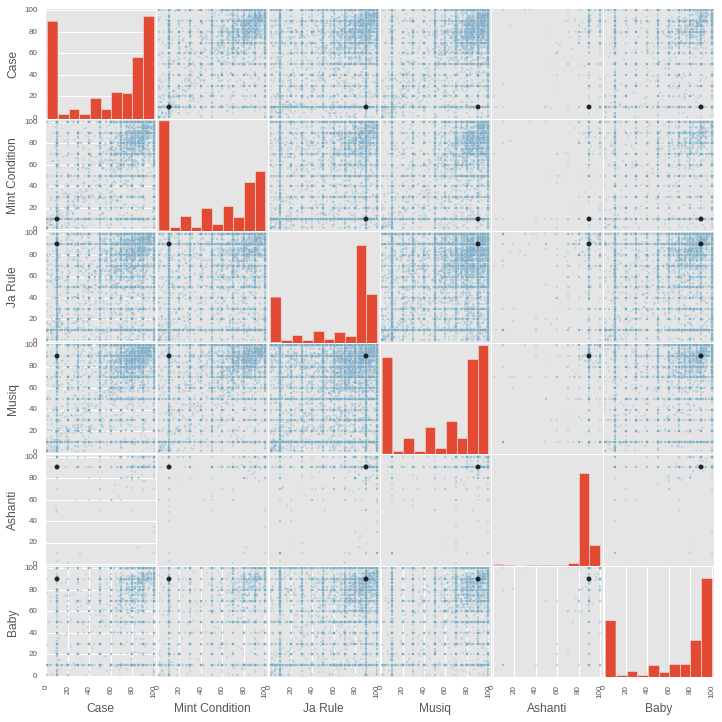

In [48]:
from lib import btq_pandas_plotting as btq
btq.scatter_matrix_and1(pivoted_df, alpha=0.2, figsize=(12,12), rowname=2);

In [89]:
uid_row_df = pivoted_df.loc[uid]
pivoted_df = pivoted_df[pivoted_df.index != uid]
uid_row_df.head()
pivoted_df.head()

aid,Case,Mint Condition,Ja Rule,Musiq,Ashanti,Baby
uid,,,,,,
10,NaN,NaN,50,NaN,NaN,NaN
20,NaN,NaN,80,70,NaN,NaN
21,NaN,NaN,90,NaN,NaN,NaN
28,NaN,NaN,100,100,NaN,100
35,10,NaN,90,90,NaN,NaN


In [78]:
#uid_row_df = pivoted_df.loc[uid]
col = 'Baby'
#for col in pivoted_df.columns:
#    print col
test_col_df = pivoted_df.pop(col)
uid_test_col_df = uid_row_df
#euclid. dist from uid. then normalized through inversion to yield a similarity value
dist_df = pivoted_df.dropna().rsub(pivoted_df.loc[uid]).pow(2).sum(axis=1).pow(.5).add(1).rdiv(1).sort_values(ascending=False)
#pearson correlation
corr_df = pivoted_df.dropna().corrwith(pivoted_df.loc[uid],axis=1).sort_values(ascending=False)
#test_col_df = pivoted_df.pop('Baby')
#test_col_df.head()

Case
Mint Condition
Ja Rule
Musiq
Ashanti


In [73]:
pivoted_df.head()

aid,Case,Mint Condition,Ja Rule,Musiq,Ashanti
uid,,,,,
2,10,10,90,90,90
10,NaN,NaN,50,NaN,NaN
20,NaN,NaN,80,70,NaN
21,NaN,NaN,90,NaN,NaN
28,NaN,NaN,100,100,NaN


In [50]:
#pivoted_df.loc[2]['Baby']=np.nan
#

In [77]:
#euclid. dist from uid. then normalized through inversion to yield a similarity value
pivoted_df.dropna().rsub(pivoted_df.loc[uid]).pow(2).sum(axis=1).pow(.5).add(1).rdiv(1).sort_values(ascending=False)

uid
2          1.000000
835513     0.166667
1652817    0.082100
1709192    0.066041
280243     0.019887
1728147    0.019234
1022864    0.018712
427575     0.018231
1937099    0.016861
487591     0.015518
354789     0.015021
46464      0.014688
1270136    0.014648
223628     0.014530
1911024    0.014521
9300       0.014127
410386     0.013713
1691582    0.013426
1305573    0.013026
453651     0.012852
629010     0.012745
1235501    0.012346
1335809    0.012252
1940848    0.012252
1939833    0.012252
29641      0.012252
823019     0.012159
569925     0.012159
1168010    0.012069
1024314    0.012023
             ...   
3881       0.007725
1494298    0.007725
222173     0.007725
864094     0.007725
1479412    0.007725
1463670    0.007725
1305831    0.007725
1606160    0.007725
1096108    0.007725
1028495    0.007725
1848186    0.007725
1014405    0.007725
894672     0.007725
1947135    0.007725
813970     0.007725
747863     0.007725
585365     0.007725
1746805    0.007725
1275214    0.007

In [75]:
#pearson correlation
#pivoted_df.corrwith(pivoted_df.loc[uid],axis=1)
print pivoted_df.loc[2]
print pivoted_df.loc[835513]
#print pivoted_df.loc[582817]
print pivoted_df.dropna().shape
pivoted_df.dropna().corrwith(pivoted_df.loc[uid],axis=1).sort_values(ascending=False)

aid
Case              10
Mint Condition    10
Ja Rule           90
Musiq             90
Ashanti           90
Name: 2, dtype: float64
aid
Case              10
Mint Condition    10
Ja Rule           95
Musiq             90
Ashanti           90
Name: 835513, dtype: float64
(217, 5)


uid
2          1.000000
835513     0.998960
1709192    0.996322
1652817    0.992341
1655700    0.968246
1937099    0.951662
410386     0.924402
427575     0.918559
654010     0.910293
1294455    0.895833
738679     0.880705
111044     0.880705
1752658    0.872872
1276960    0.840651
1142536    0.840168
1168010    0.836428
1022864    0.828453
280243     0.827430
1728147    0.824876
354789     0.823842
1660414    0.763763
94913      0.763763
1726981    0.763763
1691582    0.756644
46464      0.748455
589098     0.745356
1911024    0.742941
9300       0.741965
487591     0.705089
270960     0.692642
             ...   
1261595   -0.666667
1157633   -0.666667
36496     -0.666667
1699192   -0.666667
443188    -0.666667
1658020   -0.803700
3881            NaN
149493          NaN
222173          NaN
585365          NaN
747863          NaN
813970          NaN
864094          NaN
894672          NaN
1014405         NaN
1028495         NaN
1096108         NaN
1248762         NaN
1305831         

In [30]:
match_counts = data_df['uid'].value_counts()
print match_counts.value_counts()
match_all = match_counts[match_counts == 6]
match_all.index

1    283753
2     65647
3     23981
4     11258
5      3176
6        82
Name: uid, dtype: int64


Int64Index([1473870, 1715309,  102565, 1073763,  427575, 1301981, 1746805,
             855558, 1848957, 1428947,  507958,  888586,  835513, 1019500,
            1699192,  265617, 1728147, 1869153,  585365,  722908, 1655700,
            1740247,   89601,  128685,  864094,  788951, 1539615,  745087,
              45546, 1656418, 1709192,  747863,  565056,  453651,  354789,
            1726981,  569925, 1658020, 1928206,  184646, 1652817,  803728,
             998007, 1493594, 1810795, 1891058,  670103, 1235501,  582817,
            1939833, 1479167,  686491,  140933,  898471, 1935427,  959663,
             654010, 1940848, 1270136, 1096108,  756497, 1827793, 1882429,
            1740291, 1056287, 1260146, 1040274, 1146588, 1542898,  493864,
                  2,   99795, 1151411,  991153, 1276960, 1385900,  379893,
             823019, 1729070, 1650166, 1185739, 1937099],
           dtype='int64')

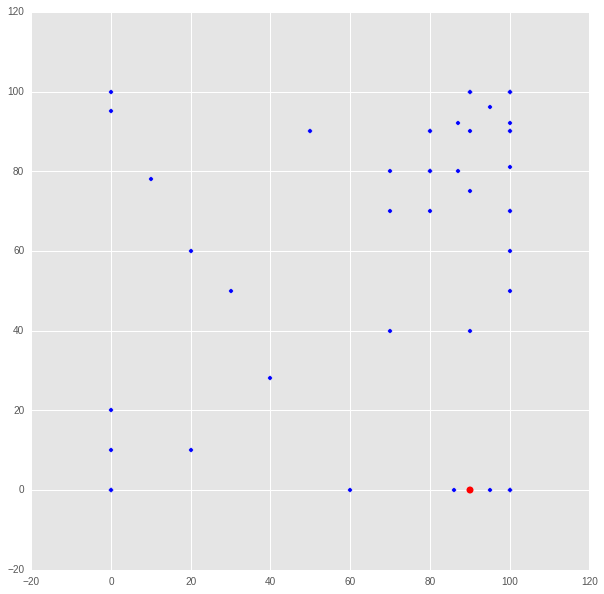

In [48]:
fig,ax = plt.subplots(figsize=(10,10))
plot_data_df = data_df[data_df['uid'].isin(match_all.index)]
plt.scatter(plot_data_df[plot_data_df['aid']==1040071]['rating'].values,plot_data_df[plot_data_df['aid']==1004623]['rating'].values,zorder=1)
plt.plot(df[df['aid']==1040071]['rating'],df[df['aid']==1004623]['rating'],'ro',zorder=2)
plt.show()

In [ ]:
axes = pd.tools.plotting.scatter_matrix(data_df, color="blue")

In [116]:
(pivoted_df.index==2).*np.array([1,0,0])

SyntaxError: invalid syntax (<ipython-input-116-c725bd3b22f8>, line 1)

In [120]:
[['b','r'][x] for x in (pivoted_df.index==2)*1]

['r',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b'

In [ ]:
(pivoted_df.index==2).dtype.kind

In [103]:
np.random.rand(5)

array([ 0.51459551,  0.36783475,  0.56378024,  0.28488282,  0.56356364])

In [91]:
import matplotlib.cm as cm
cmap = 'magma'
colormap = cm.get_cmap('magma')
#colors = lma
colors = pd.compat.lmap(colormap,np.linspace(0,1,num=8))
colors

[(0.001462, 0.000466, 0.013866, 1.0),
 (0.13505300000000001, 0.068390999999999993, 0.315, 1.0),
 (0.372116, 0.092815999999999996, 0.49905300000000002, 1.0),
 (0.59450800000000004, 0.175701, 0.50124100000000005, 1.0),
 (0.82888600000000001, 0.26222899999999999, 0.43064400000000003, 1.0),
 (0.97338100000000005, 0.46151999999999999, 0.36196499999999998, 1.0),
 (0.99734100000000003, 0.733545, 0.50516700000000003, 1.0),
 (0.98705299999999996, 0.99143800000000004, 0.74950399999999995, 1.0)]

In [2]:
d = defaultdict(lambda: defaultdict(int))
tic = timeit.default_timer()
with open('data/ydata-ymusic-user-artist-ratings-v1_0_2002.txt') as infile:
    for line in infile:
        #print line
        vals = re.split('\t',line)
        #print vals
        d[vals[0]][vals[1]]= int(vals[2].strip())
toc=timeit.default_timer()
print toc - tic
print d['1']         

0.241866111755
defaultdict(<type 'int'>, {'1008916': 100, '1042768': 100, '1016885': 100, '1024496': 100, '1036157': 90, '1033451': 100, '1007035': 100, '1041557': 90, '1045525': 100, '1098798': 90, '1017874': 100, '1020778': 100, '1007723': 100, '1007098': 100, '1020524': 100, '1000125': 90, '1047584': 100, '1006978': 90, '1020560': 100, '1016419': 100, '1019522': 100, '1024006': 100, '1016470': 100, '1006373': 100, '1024759': 100, '1017881': 100, '1043712': 100, '1008659': 100, '1037847': 100, '1029612': 100, '1024635': 100, '1034801': 100, '1045024': 100, '1021623': 100, '1012809': 70, '1014635': 100, '1016522': 100, '1053507': 90, '1024015': 100, '1019512': 100})
